# Simulation study of logistic regression

This notebook is an example of using Bayesian logisitc regression for subset choice modeling on synthetic data.

In [92]:
import simulation_tools as simu
import arviz as az
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef

In [93]:
# shortcuts
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# plotting settings
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [94]:
# experiment parameters
rng_u = np.random.default_rng(seed=26121991)
nItems = 15
nTrials = 200  # nr trials
nTrain = 100 # trials used for training
nTest = nTrials - nTrain
nPoints = np.repeat(nItems, nTrials)  # points per tiral
minx, maxx = -2, 2 # box extent
radius = 0.2 # Matern thinning radius

## Generating synthetic data
Here we sample data on which to run our estimator. The independent variables are the coordiates of points sampled uniformly in a square. The dependent variables are sampled using Matérn type III thinning. This is a dependent thinning model, which induces negative dependece in the labels. Our goal is to generate a squence of datasets with varying dependence, and to evaluate the performance of our model on each dataset. Repeating the exercise over multiple models gives us a way to compare the efficacy of various models at classifying labels under negative dependence.

Sampling the dependent variables, or _labels_ $Y$ proceeds in two stages. First, there is independent, or _poisson_ thinning according to probabilities $1- p(u)$ where $u$ is a point in the trial. In other words each point $u$ is independently retained with probability $p(u)$. Second, the retained points are subject to Matérn Type III thinning, with some given radius $r$. 

In [95]:
# sample points
lons = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # X
lats = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # Y
points = [np.vstack([lons[i], lats[i]]).T for i in range(nTrials)] 

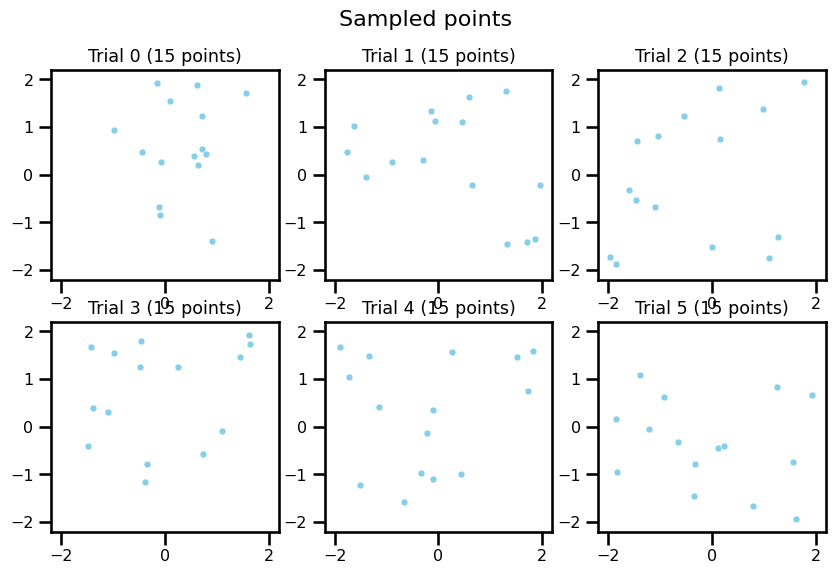

In [96]:
# make datasets
Xs = []
for i in range(nTrials):
    Xs.append(np.vstack((np.ones(nPoints[i]), np.sqrt(lons[i]**2 + lats[i]**2), lats[i], lons[i])).T)
Zs = []
for i in range(nTrials):
    Zs.append([distance_matrix(points[i], points[i])])

simu.plot_points(points, 0, title="Sampled points")

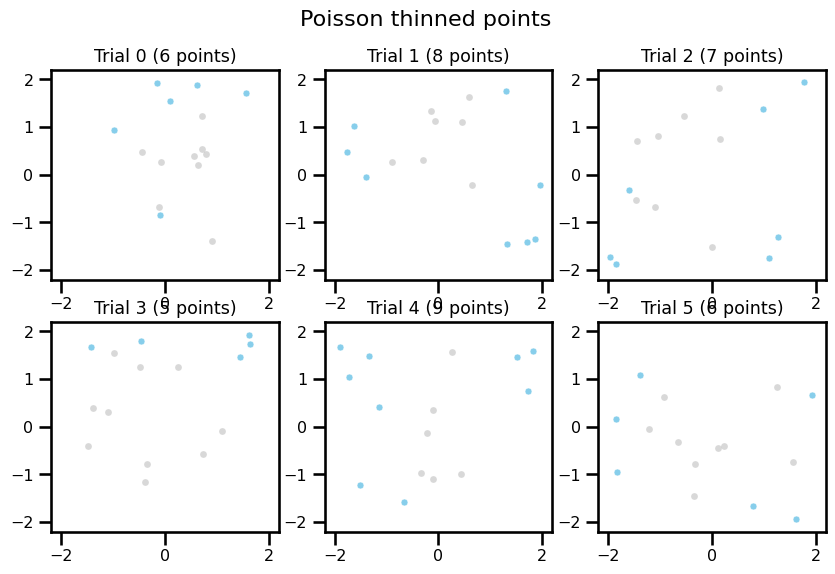

In [97]:
# poisson thinning
rng_t = np.random.default_rng(seed=18842524)
beta0 = -5.0
beta1 = 2.5

# thinned labels
labels = [np.ones(shape=n).astype(bool) for n in nPoints] # all labels are 1
probs = [np.exp(beta0 + X[:, 1]*beta1) for X in Xs]
unifs = [rng_t.uniform(0, 1, size=n) for n in nPoints] 
retain = [(unifs[i] < probs[i]) for i in range(nTrials)]
labels = [labels[i] * retain[i] for i in range(nTrials)]

simu.plot_points(points, 0.0, labels=labels, title="Poisson thinned points")

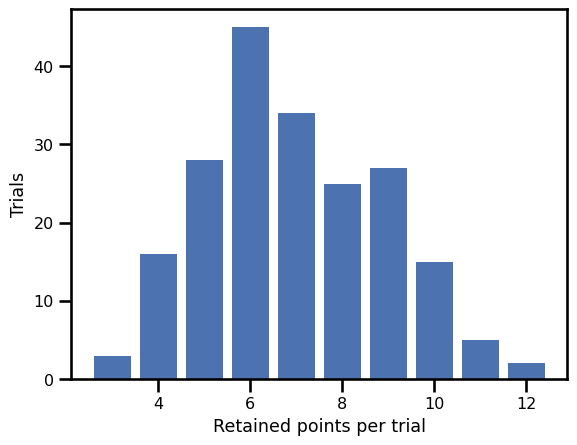

In [98]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

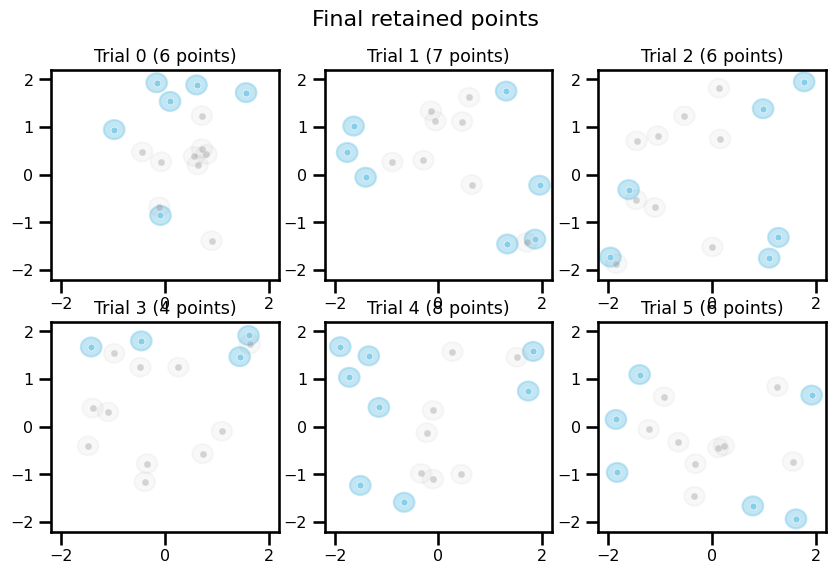

In [99]:
# sample matern
labels = [simu.sample_matern_iii(Xs[i][:, 2], Zs[i][0], radius, labels=labels[i]) for i in range(nTrials)]
simu.plot_points(points, radius, labels=labels, title="Final retained points")

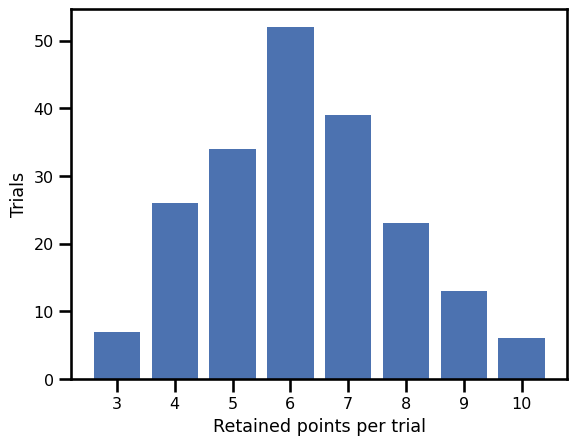

In [100]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

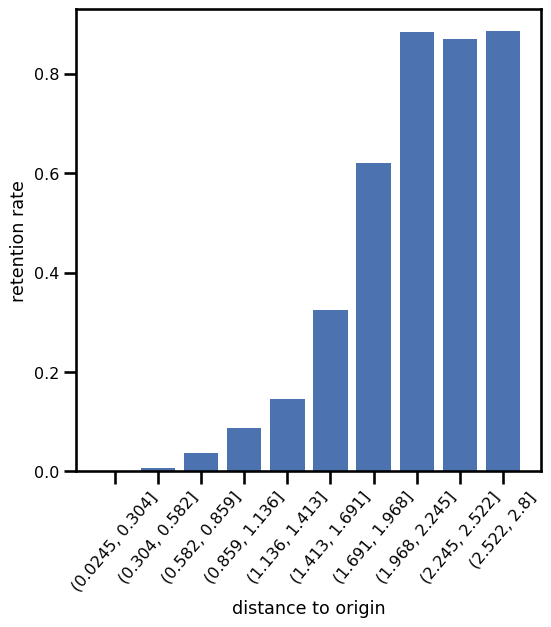

In [101]:
# plot x-bins vs percentage included
data = np.array([X[:, 1] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('distance to origin')
plt.xticks(rotation=50);

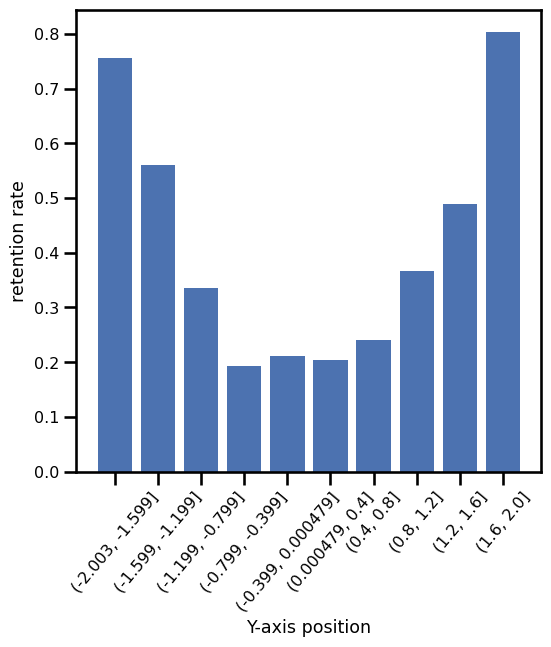

In [102]:
# plot x-bins vs percentage included
data = np.array([X[:, 2] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('Y-axis position')
plt.xticks(rotation=50);

## Bayesian Logistic regression

In [103]:
# prepare the data
X_train = tf.constant(np.vstack(Xs[:nTrain]), dtype=dtype)
y_train = tf.constant(np.hstack(labels[:nTrain]), dtype=dtype)
X_test = tf.constant(np.vstack(Xs[nTrain:]), dtype=dtype)
y_test = tf.constant(np.hstack(labels[nTrain:]), dtype=dtype)
print("There are %d training observations." % X_train.shape[0])
print("There are %d testing observations." % X_test.shape[0])

There are 1500 training observations.
There are 1500 testing observations.


In [104]:
# save test outcomes
folder = 'data/logit/'
np.savetxt(folder + f"y_test_{nItems}_items_rad{radius:.1f}.csv", y_test, delimiter=",")
y_test_saved = np.genfromtxt(folder + f"y_test_{nItems}_items_rad{radius:.1f}.csv", delimiter=",", usemask=False)
print(np.all(y_test == y_test_saved))

True


### Make prior model

In [105]:
# generate prior
nDims = X_train.shape[-1]
print("There are %d features." % nDims)

# prior over beta0 and beta1
means_prior = np.zeros(nDims)
sigma_prior = 10

beta_prior = tfd.MultivariateNormalDiag(loc=means_prior,
                                        scale_diag=np.ones(nDims)*sigma_prior,
                                        name='beta_prior')

There are 4 features.


### Make posterior model

In [106]:
def make_logit_logposterior(prior, X_train, y_train):
    """Functional closure for loglikelihood function.
    """
    
    def _logposterior(beta):
        """Compute linear response and evaluate.
        """
        return simu.logit_log_prob(beta, X_train, y_train) + prior.log_prob(beta)
    
    return _logposterior

# get log posterior
log_posterior = make_logit_logposterior(beta_prior, X_train, y_train)

Test a function and gradient call on the log-likelihood.

In [107]:
# test function and gradient call
params = tf.constant([[1, 0, 0, 0]], dtype=dtype)
[funval, grads] = tfp.math.value_and_gradient(log_posterior, params)
print("Function Value: ", funval)
print('Gradient: \n', grads)

Function Value:  tf.Tensor([-1383.78362578], shape=(1,), dtype=float64)
Gradient: 
 tf.Tensor([[-497.59786795 -492.88542121   10.72780543  -21.41461823]], shape=(1, 4), dtype=float64)


In [108]:
# setup NUTS for Bayesian Inference
nChains = 25
num_burnin = 100
num_results = 500

# generator for uniform points 
rng_p = np.random.default_rng(seed=3545412091)
initial_state = rng_p.uniform(size=(nChains, nDims)) * 5

# define nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=log_posterior,
    step_size=np.float64(0.1)
    )

# nuts adaptive kernel
nuts_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    nuts_kernel,
    num_adaptation_steps=int(num_burnin * 0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    target_accept_prob=0.7
)

@tf.function
def run_chain(initial_state, num_results=5000, num_burnin_steps=0):
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=nuts_adaptive_kernel,
      trace_fn=lambda current_state, kernel_results: kernel_results)

In [109]:
# run chain & get results
samples, kernel_results = run_chain(initial_state, num_results, num_burnin)

In [110]:
# summaries
results = samples.numpy().T
data = az.convert_to_dataset({'beta0': results[0, :],
                              'beta1': results[1, :],
                              'beta2': results[2, :],
                              'beta3': results[3, :]}
                              )

# get log accept ratio
log_accept_ratio = kernel_results.inner_results.log_accept_ratio
p_accept = tf.math.exp(tfp.math.reduce_logmeanexp(tf.minimum(log_accept_ratio, 0.)))
print("Acceptance ratio: \t %.3f" % p_accept.numpy())

Acceptance ratio: 	 0.805


In [111]:
# n-eff
print(az.ess(data)['beta0'].values)
print(az.ess(data)['beta1'].values)
print(az.ess(data)['beta2'].values)
print(az.ess(data)['beta3'].values)

2780.0772850031535
2819.8767958783114
17052.409521526635
14654.244776112764


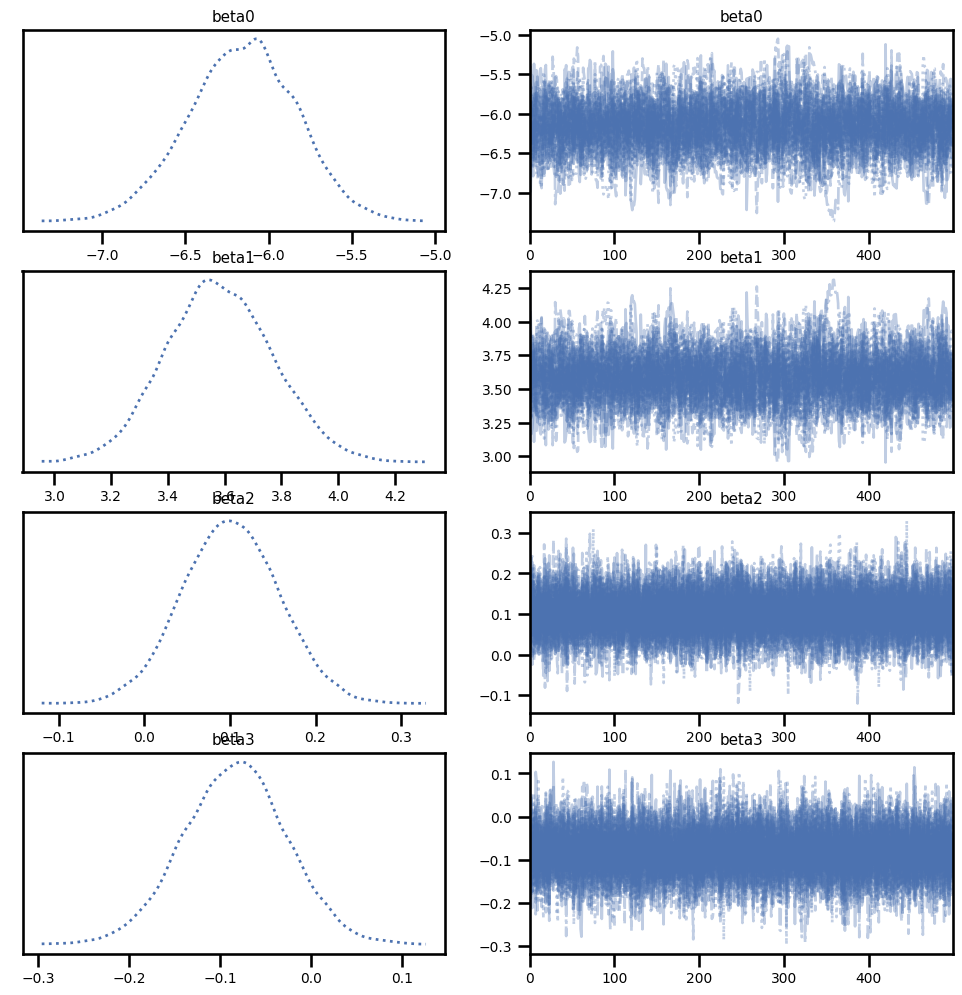

In [112]:
# trace plot
axes = az.plot_trace(data, combined=True, compact=True, figsize=(12, 12))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/logit/traceplot_{nItems}_{radius}.png')
plt.show()

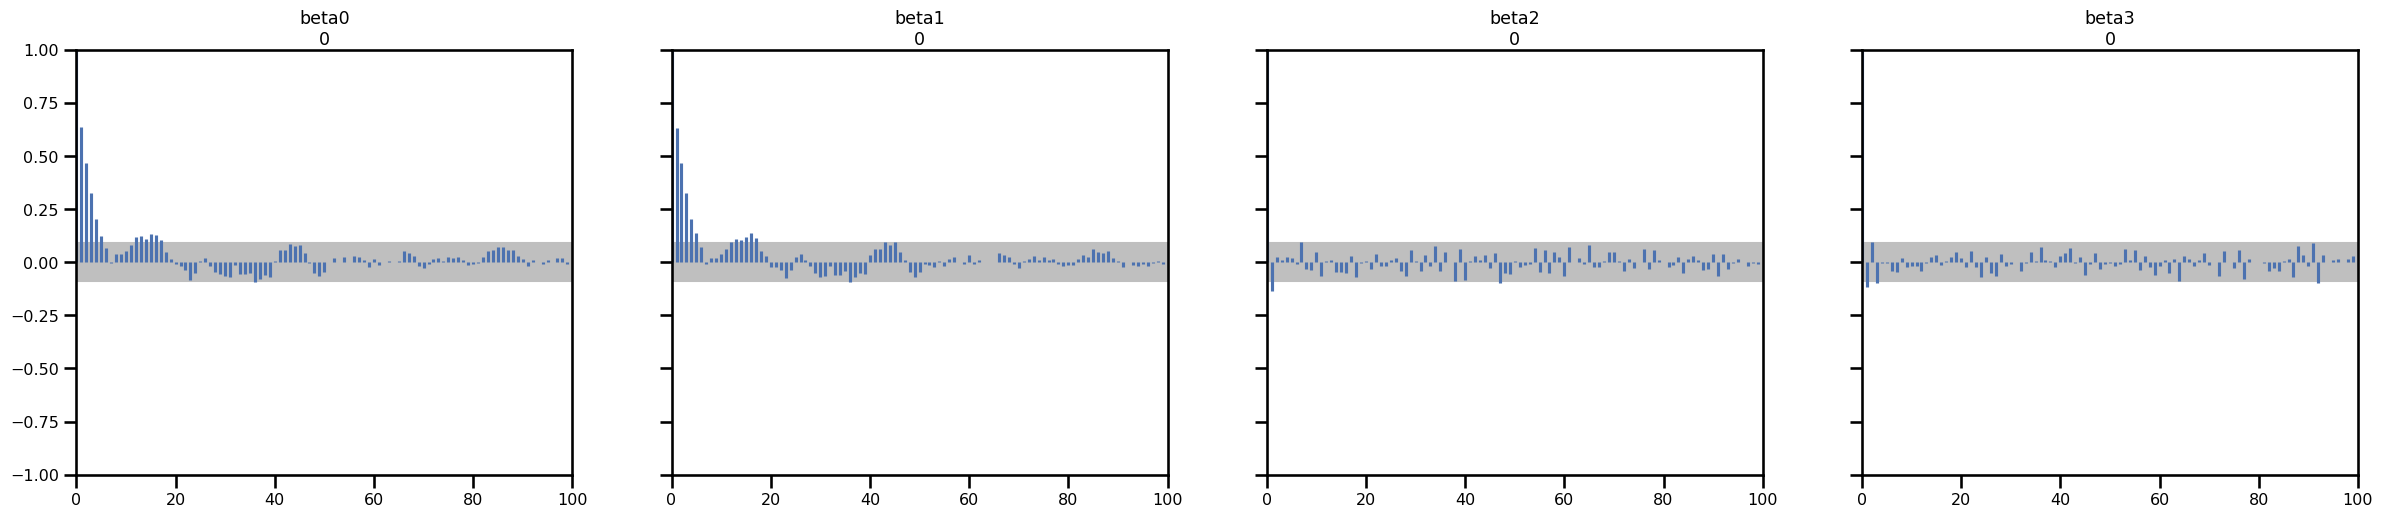

In [113]:
# autocorrelation plots
axes = az.plot_autocorr(data.sel(chain=[0]))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/logit/autrocorrelation_{nItems}_{radius}.png')
plt.show()

In [114]:
az.rhat(data) #.to_netcdf(f'data/logit/rhat_{nItems}_{radius:.2f}.json')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta0    float64 1.006
    beta1    float64 1.007
    beta2    float64 1.002
    beta3    float64 1.001

# Make and save predictions

In [117]:
# collect betas
betas = samples[-1, :, :]

# make predictions
rng = np.random.default_rng(20122221201)
p_pred = simu.logit_pred_prob(betas, X_test).numpy()

predictions = rng.binomial(1, p=p_pred)
print(f"Saving predictions of shape {predictions.shape}.")

# save predictions
folder = 'data/logit/'
np.savetxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", predictions, delimiter=",")


Saving predictions of shape (25, 1500).


# Summarize results

In [128]:
# read from file
res = np.genfromtxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", delimiter=",", usemask=False)
print(f"Loaded predictions of shape {res.shape}.")

res = res.reshape(nChains, nItems, nTest)
y_test = y_test #.numpy().reshape(nItems, nTest).T

# sample predictions and evaluate
mcc, std = simu.summarize_mcc(res, y_test)

print(f"Mean MCC is {mcc:.2f} (SE {std:.4f})")

Loaded predictions of shape (25, 1500).
Mean MCC is 0.42 (SE 0.0202)
